# Import Library

In [36]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc  
import seaborn as sns
from pathlib import Path
import random

import warnings

# 경고 무시
warnings.filterwarnings("ignore")

plt.rcParams['axes.unicode_minus'] = False  
plt.rcParams['font.family'] = 'AppleGothic'
sns.set(font="AppleGothic", 
        rc={"axes.unicode_minus":False}, style='white')

### 1. 데이터 개요
- 📂 디렉토리/파일 구조 설명
- 🏷 어노테이션 포맷 (synthetic만 제공됨)
- 📏 이미지 수/해상도 요약 (synthetic vs real vs test)

# 📁 1. 데이터 개요

### 1.1 디렉토리 및 파일 구조

```bash
📂 data/
├── 📂 train/
│   ├── 📂 images/      # 학습용 synthetic 이미지
│   └── 📂 labels/      # YOLO 포맷 바운딩 박스 라벨 (.txt)
│
├── 📂 val/
│   ├── 📂 images/      # 검증용 synthetic 이미지
│   └── 📂 labels/      # YOLO 포맷 라벨
│
└── 📂 test/
    └── 📂 images/      # 테스트용 real 이미지 (라벨 없음)

📄 classes.txt                 # 클래스 이름 리스트 (YOLO 포맷 기준)
📄 sample_submission.csv      # 제출 예시 파일
📄 submission.csv             # 최종 제출 파일
📄 yolo8s.yaml                # YOLOv8 모델 아키텍처 정의 파일
📄 yolo_params.yaml           # 학습 파라미터 설정 파일
📄 train.py                   # 학습 실행 스크립트
📄 predict.py                 # 추론 스크립트
📄 convert_preds_to_csv.py    # YOLO 추론 결과를 제출 형식으로 변환
📄 EDA.ipynb                  # EDA 노트북
```

---

### 1.2 라벨 포맷 (YOLO Format)

- `.txt` 파일이 이미지와 같은 이름으로 존재 (`0001.txt`, `0002.txt` 등)
- **YOLO 라벨 형식**:
  ```
  <class_id> <x_center> <y_center> <width> <height>
  ```
  - 모든 값은 **0~1 사이**의 상대 좌표
  - 중심 좌표(x, y), 폭, 높이 기준

---

### 1.3 데이터 수 및 해상도 (요약)

| 구분         | 이미지 수  | 라벨 포함 여부 | 해상도 예시       |
|--------------|------------------|----------------|-------------------|
| Train        | 431 (Synthetic) | ✅ 있음        | 1920x1080     |
| Validation   | 69 (Synthetic) | ✅ 있음        | 1920x1080  |
| Test         | 164       | ❌ 없음        | 저해상도~고해상도까지 다양하게 분포   |

> ⛔️ test set은 real 도메인의 이미지로만 구성되어 있으며 라벨이 제공되지 않습니다.  

In [3]:
from PIL import Image

train_img = Image.open('data/train/images/000000000.png')
test_img = Image.open('data/test/images/0002.jpg')

print(train_img.size)
print(test_img.size)

(1920, 1080)
(1080, 1920)


In [18]:
paths = {
    "train": Path("data/train/images"),
    "val": Path("data/val/images"),
    "test": Path("data/test/images"),
}

# 해상도 정보를 수집하는 함수
def collect_resolutions(img_dir):
    resolutions = []
    if not img_dir.exists():
        return resolutions
    for fname in os.listdir(img_dir):
        if fname.endswith((".jpg", ".png")):
            img_path = img_dir / fname
            img = cv2.imread(str(img_path))
            if img is not None:
                h, w = img.shape[:2]
                resolutions.append((w, h))
    return resolutions

# 각 폴더별 해상도 수집
res_data = []
for split, path in paths.items():
    res_list = collect_resolutions(path)
    for res in res_list:
        res_data.append({"split": split, "resolution": res,
                         "width": res[0], "height": res[1]})

# DataFrame 생성 및 시각화
df_res = pd.DataFrame(res_data)
# 전체 이미지 해상도 분포
df_res


split    resolution  width  height
0    train  (1920, 1080)   1920    1080
1    train  (1920, 1080)   1920    1080
2    train  (1920, 1080)   1920    1080
3    train  (1920, 1080)   1920    1080
4    train  (1920, 1080)   1920    1080
..     ...           ...    ...     ...
659   test    (640, 640)    640     640
660   test  (1080, 1920)   1080    1920
661   test  (1080, 1920)   1080    1920
662   test  (1080, 1920)   1080    1920
663   test  (1080, 1920)   1080    1920

[664 rows x 4 columns]

In [ ]:
# 전체 데이터셋에서의 해상도 분포 (실제 시각화를 위한 count 집계 필요)
df_count = df_res.groupby(["split", "resolution"]).size().reset_index(name="count")
df_count

split    resolution  count
0    test    (640, 640)      6
1    test  (1080, 1920)     94
2    test  (1835, 1616)      1
3    test  (2547, 2605)      1
4    test  (2840, 2778)      1
5    test  (2843, 3723)      1
6    test  (2880, 3840)      3
7    test  (3024, 3024)     20
8    test  (3024, 4032)     37
9   train  (1920, 1080)    431
10    val  (1920, 1080)     69

In [10]:
df_count.info()
df_count["resolution"] = df_count["resolution"].apply(lambda x: f"{x[0]}x{x[1]}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   split       11 non-null     object
 1   resolution  11 non-null     object
 2   count       11 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 392.0+ bytes


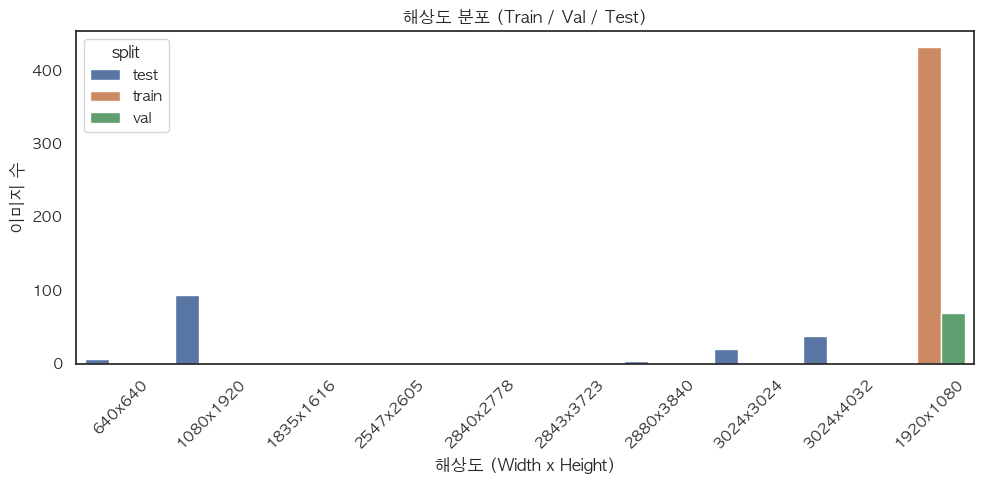

In [12]:
# 시각화
plt.figure(figsize=(10, 5))
sns.barplot(data=df_count, x="resolution", y="count", hue="split")
plt.title("해상도 분포 (Train / Val / Test)")
plt.xlabel("해상도 (Width x Height)")
plt.ylabel("이미지 수")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

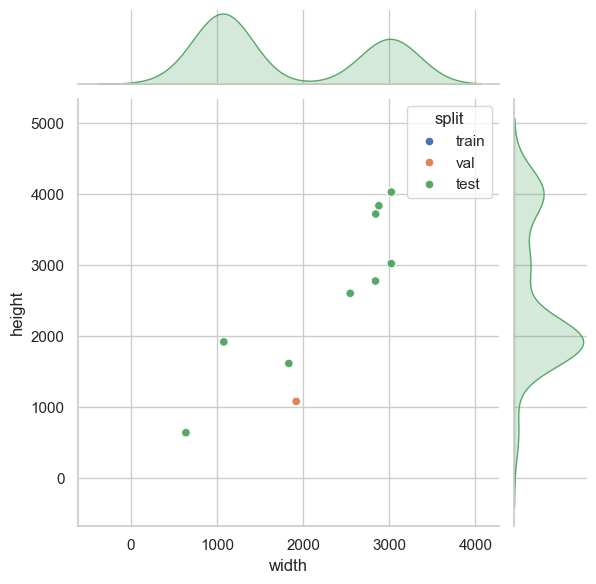

In [31]:
sns.jointplot(data=df_res, x="width", y="height", hue="split", kind="scatter")


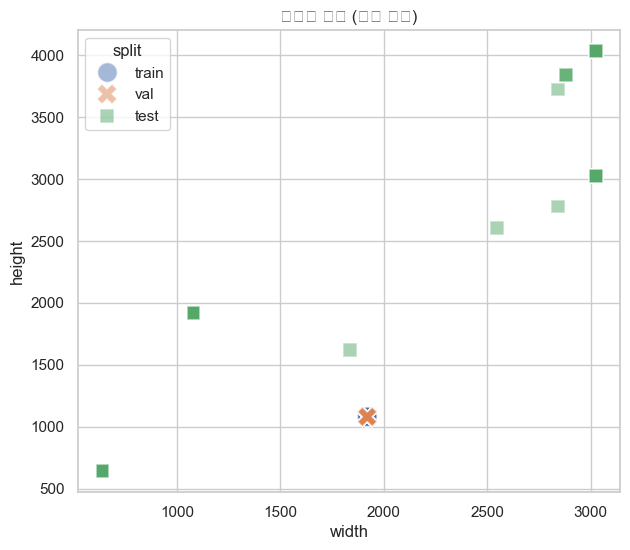

In [35]:
# 투명도와 마커 모양 다르게
plt.figure(figsize=(7, 6))

ax = sns.scatterplot(
    data=df_res,
    x="width",
    y="height",
    hue="split",
    style="split",
    s=200,
    alpha=0.5
)
plt.title("해상도 분포 (겹침 없이)")
plt.grid(True)
plt.show()


## 해상도 분포

### 🔹 해상도별 split 구성

| 해상도          | 포함된 Split     |
|------------------|------------------|
| `640x640`        | test             |
| `1080x1920`      | test             |
| `1835x1616`      | test             |
| `2547x2605`      | test             |
| `2843x2723`      | test             |
| `2880x3840`      | test             |
| `3024x3024`      | test             |
| `3024x4032`      | test             |
| `1920x1080`      | train, val       |

---

### 📌 주요 해석 포인트

✅ 1. **Test 데이터의 해상도 다양성** 매우 높음
- 고해상도 (`3024x4032`, `2880x3840`)부터 중간 해상도 (`1835x1616`)까지 **매우 다양한 해상도**
- **이질적인 사이즈 분포** → test domain은 일반화가 어려운 조건

✅ 2. **Train/Val은 오직 1920x1080**
- 학습 데이터는 매우 균일한 해상도
- 모델이 다양한 해상도에 robust하지 못할 가능성 높음

✅ 3. **도메인 갭 존재**
- 해상도만 봐도 train/val vs test 간 **도메인 차이** 명확함
- domain adaptation이나 resizing 전략 필수

---

💡 실전 대응 전략

| 전략 | 설명 |
|------|------|
| 🔁 Resize 정규화 | test 이미지들을 `train` 해상도(1920x1080) 기준으로 resize 또는 padding |
| 🧪 TTA (Test Time Augmentation) | 다양한 비율 조정 후 ensemble |
| 🔍 Aspect Ratio Matching | resize 시 비율 유지하는 `letterbox` 방식 추천 |
| 🧩 Training 시 Augmentation 강화 | 다양한 scale, crop, mosaic 등 사용 |


✅ Resize + Letterbox (기본 전처리)

✅ ColorJitter / Gaussian Blur Augmentation

✅ Histogram Matching → 정량적으로 HSV 분포 맞추기

✅ Pseudo-labeling (confidence 기반) Fine-tuning

⛳️ 가능하면: CycleGAN 변환 이미지 → 추가 학습

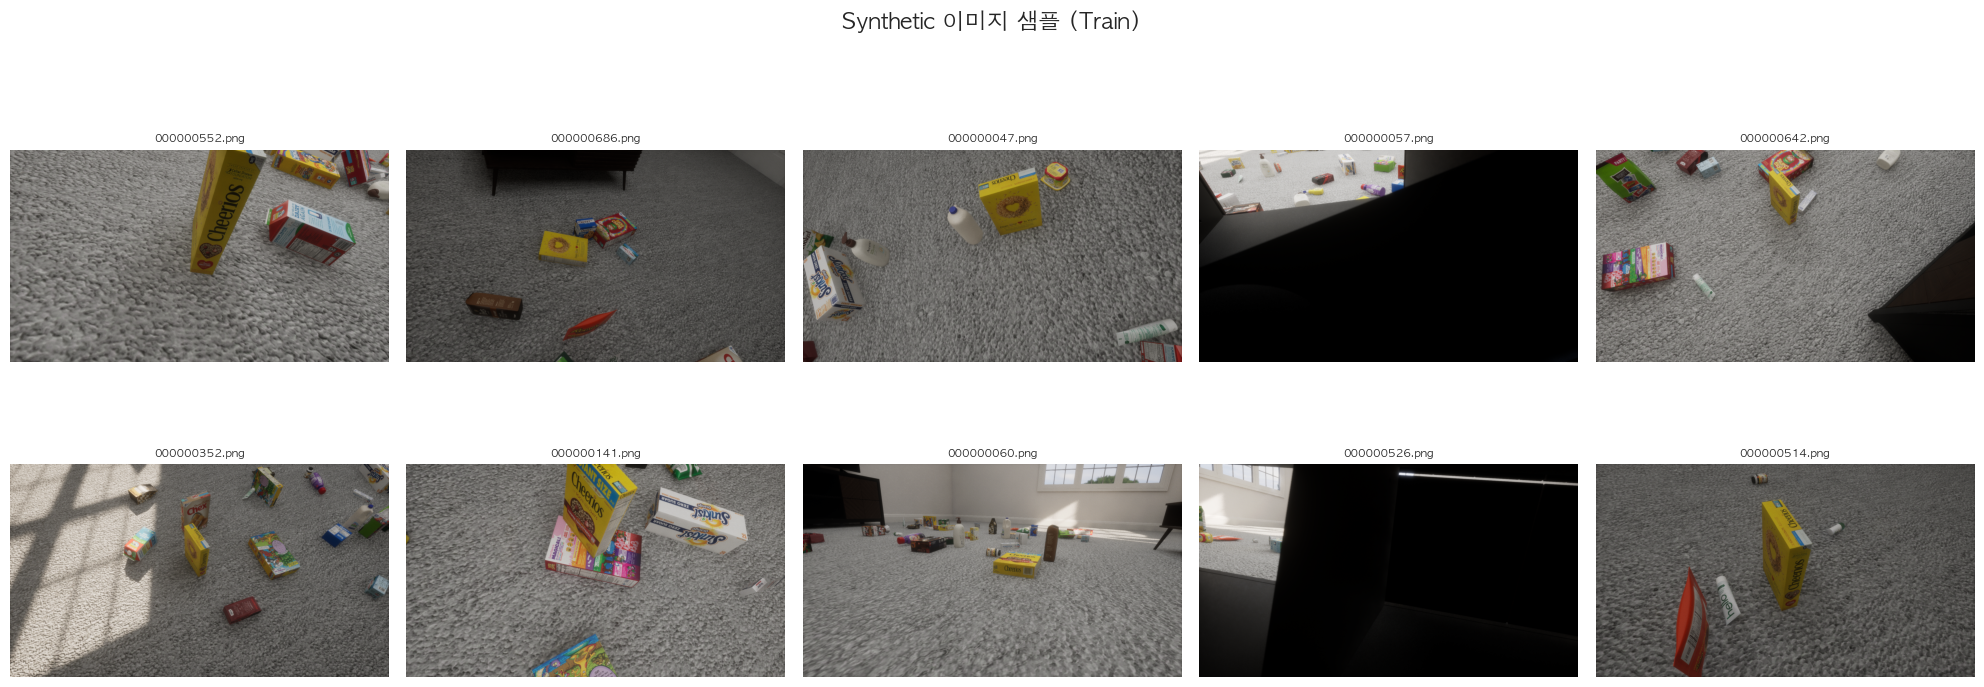

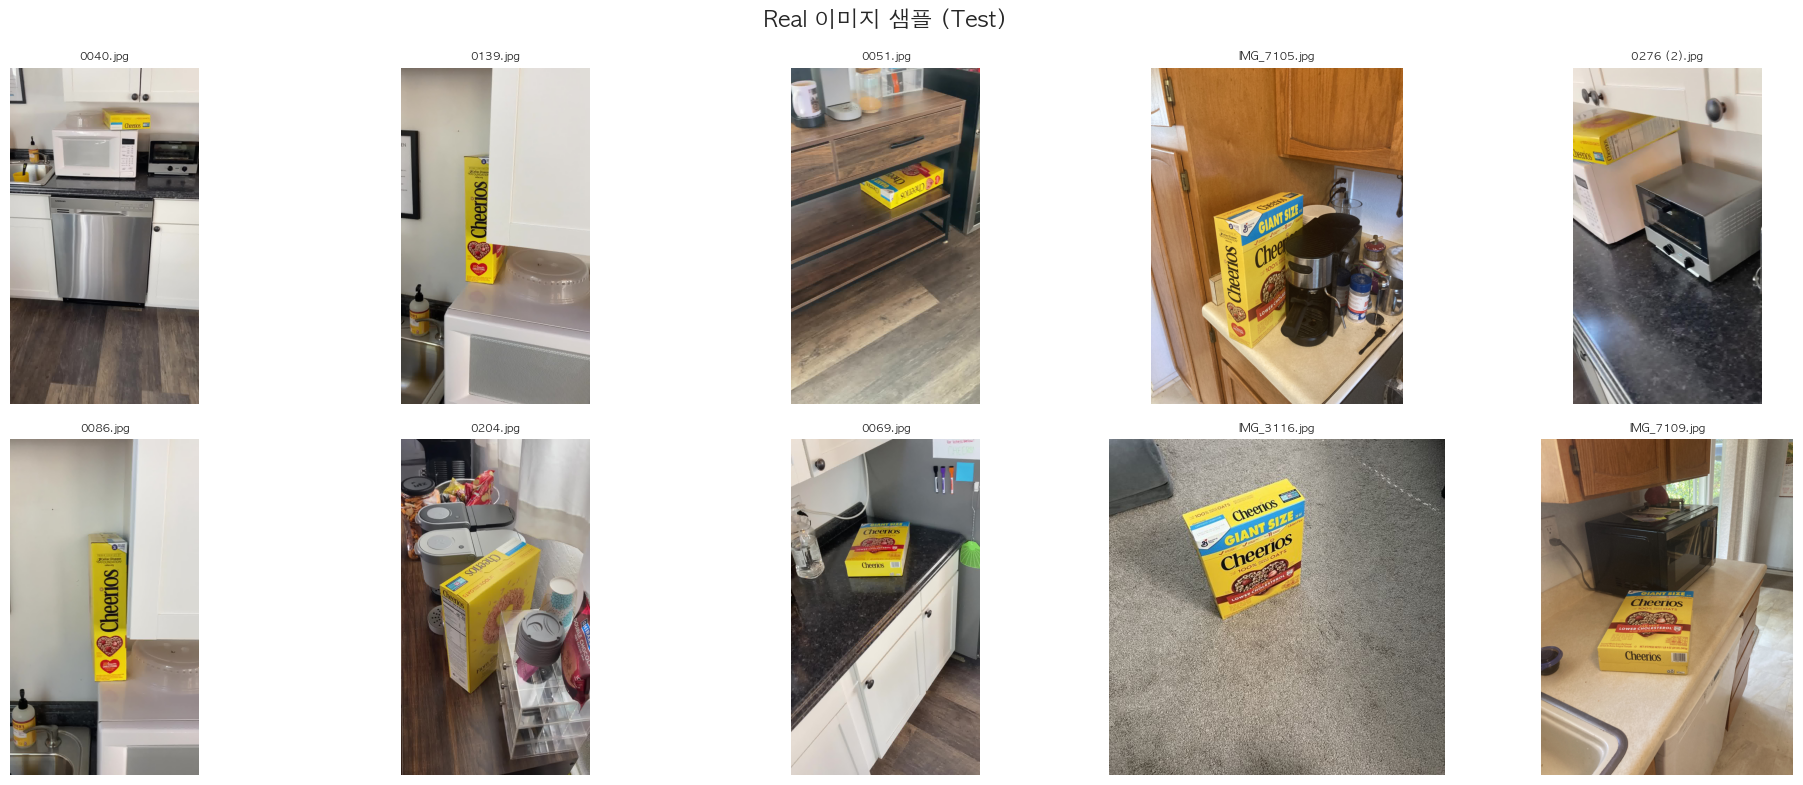

In [38]:
# 이미지 경로 설정
train_dir = Path("data/train/images")
test_dir = Path("data/test/images")

def show_sample_images(img_dir, title, n=10):
    img_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))]
    sample_files = random.sample(img_files, min(n, len(img_files)))

    plt.figure(figsize=(20, 8))
    for i, fname in enumerate(sample_files):
        img = cv2.imread(str(img_dir / fname))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(2, 5, i + 1)
            plt.imshow(img)
            plt.title(fname, fontsize=8)
            plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# 시각화 실행
show_sample_images(train_dir, "Synthetic 이미지 샘플 (Train)")
show_sample_images(test_dir, "Real 이미지 샘플 (Test)")


In [2]:
train_img_dir = "data/train/images"
val_img_dir = "data/val/images"
test_img_dir = "data/test/images"

train_count = len([f for f in os.listdir(train_img_dir) if f.endswith(('.png', '.jpg','.jpeg'))])
val_count = len([f for f in os.listdir(val_img_dir) if f.endswith(('.png', '.jpg','.jpeg'))])
test_count = len([f for f in os.listdir(test_img_dir) if f.endswith(('.png', '.jpg','.jpeg'))])

print(f"Train images: {train_count}")
print(f"Validation images: {val_count}")
print(f"Test images: {test_count}")

Train images: 431
Validation images: 69
Test images: 164


In [39]:
# Set paths
train_img_dir = Path("data/train/images")
test_img_dir = Path("data/test/images")

def load_sample_images(img_dir, num_images=100):
    files = sorted([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))])[:num_images]
    images = []
    for fname in files:
        img_path = img_dir / fname
        img = cv2.imread(str(img_path))
        if img is not None:
            images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return images

def analyze_images(images):
    hsv_stats = {"hue": [], "saturation": [], "value": []}
    brightness = []
    edge_density = []
    laplacian_var = []
    saturation = []

    for img in images:
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(hsv)

        brightness.append(np.mean(v))
        saturation.append(np.mean(s))

        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, 100, 200)           # 엣지 검출 (엣지 존재여부)
        edge_density.append(np.sum(edges > 0) / edges.size)
        # edge_density: 이미지에서 edge가 차지하는 픽셀 비율 “이 이미지에는 에지가 얼마나 많이 분포되어 있는가?”

        laplacian_var.append(cv2.Laplacian(gray, cv2.CV_64F).var()) # 엣지 검출
        # cv2.CV_64F: 64비트 부동소수점(double) 형식
        # 입력 이미지 (보통 uint8 형식)는 음수 표현이 불가능하기 때문에
        # laplacian_var: 픽셀별 경계 강도의 분산(variance) → 선명할수록 분산이 큼 “이 이미지가 얼마나 날카롭고, 선명한가?”

    return saturation, brightness, edge_density, laplacian_var

# Load and analyze
train_images = load_sample_images(train_img_dir)
test_images = load_sample_images(test_img_dir)

train_saturation, train_brightness, train_edges, train_blur = analyze_images(train_images)
test_saturation, test_brightness, test_edges, test_blur = analyze_images(test_images)


In [40]:
df_stats = pd.DataFrame({
    "domain": ["synthetic"] * len(train_brightness) + ["real"] * len(test_brightness),
    "brightness": train_brightness + test_brightness,
    "saturations": train_saturation + test_saturation,
    "edge_density": train_edges + test_edges,
    "laplacian_var": train_blur + test_blur
})
# Synthetic vs Real - 이미지 통계 비교
df_stats

domain  brightness  saturations  edge_density  laplacian_var
0    synthetic  165.659515    13.787160      0.045035     396.840887
1    synthetic  135.283487    15.396118      0.067174     432.479997
2    synthetic   47.814589    31.919033      0.003325     150.878787
3    synthetic  157.731689    18.910190      0.088191     614.390422
4    synthetic  119.013183    37.641250      0.019829     318.816566
..         ...         ...          ...           ...            ...
195       real  143.918542    76.209382      0.139390    2022.079091
196       real  153.253613    67.310364      0.243787    3618.745899
197       real  164.804619    75.675234      0.226033    3673.431296
198       real  145.263960    41.791768      0.294233    9120.204293
199       real  147.174988    55.522991      0.322537    6555.964929

[200 rows x 5 columns]

In [81]:
df_stats[df_stats['domain']=='real'].describe()

brightness  saturations  edge_density  laplacian_var
count  100.000000   100.000000    100.000000     100.000000
mean   141.095916    54.242060      0.035828     417.687715
std     16.560693    21.767107      0.054480    1249.745027
min    104.532561    23.321743      0.010439      40.432093
25%    128.866138    36.972552      0.015890      80.016517
50%    140.672434    50.645952      0.019661     118.980794
75%    152.610847    66.138618      0.031324     177.446292
max    177.817902   115.709703      0.322537    9120.204293

In [ ]:
# 3. Laplacian Variance (Blur 정도)
plt.figure(figsize=(6, 4))
sns.kdeplot(data=df_stats, x="laplacian_var", hue="domain", fill=True, palette=palette)
plt.title("Laplacian Variance (Blur/Sharpness) (Synthetic vs Real)")
plt.xlabel("Variance of Laplacian")
plt.ylabel("Density")
plt.show()

In [43]:
# 도메인별 색상
palette = {"synthetic": "tab:blue", "real": "tab:orange"}

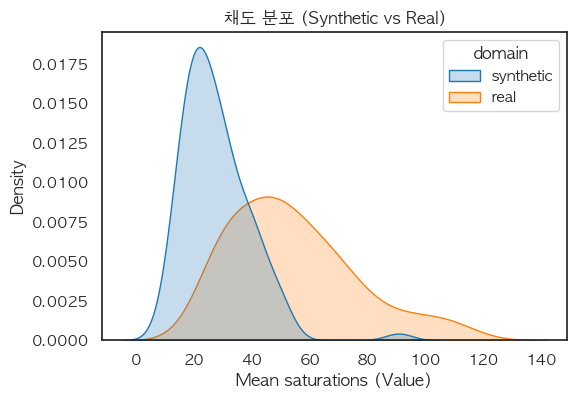

In [69]:
plt.figure(figsize=(6, 4))
sns.kdeplot(data=df_stats, x="saturations", hue="domain", fill=True, palette=palette)
plt.title("채도 분포 (Synthetic vs Real)")
plt.xlabel("Mean saturations (Value)")
plt.ylabel("Density")
plt.show()

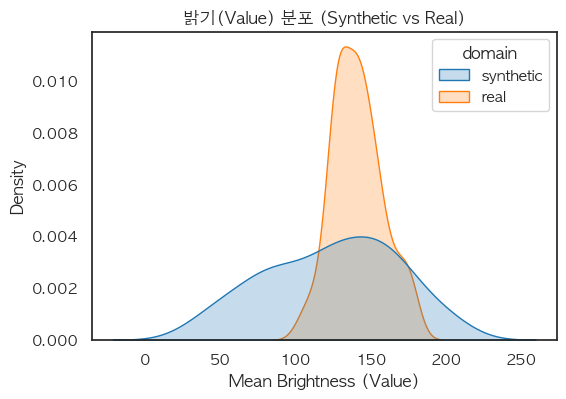

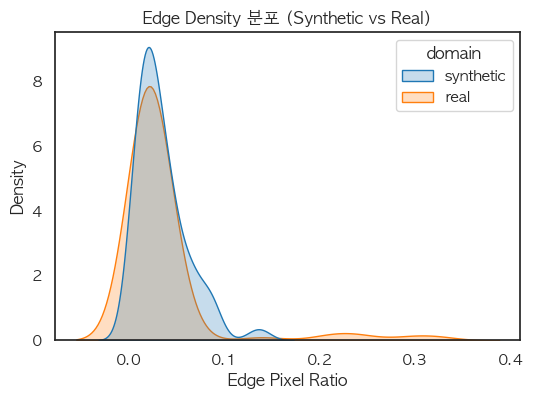

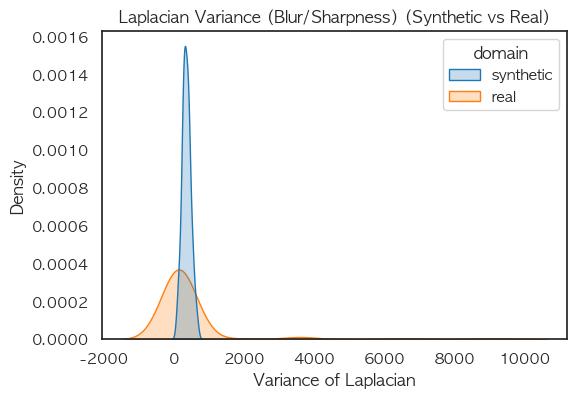

In [71]:
# 1. 밝기 분포
plt.figure(figsize=(6, 4))
sns.kdeplot(data=df_stats, x="brightness", hue="domain", fill=True, palette=palette)
plt.title("밝기(Value) 분포 (Synthetic vs Real)")
plt.xlabel("Mean Brightness (Value)")
plt.ylabel("Density")
plt.show()

# 2. Edge Density 분포
plt.figure(figsize=(6, 4))
sns.kdeplot(data=df_stats, x="edge_density", hue="domain", fill=True, palette=palette)
plt.title("Edge Density 분포 (Synthetic vs Real)")
plt.xlabel("Edge Pixel Ratio")
plt.ylabel("Density")
plt.show()

# 3. Laplacian Variance (Blur 정도)
plt.figure(figsize=(6, 4))
sns.kdeplot(data=df_stats, x="laplacian_var", hue="domain", fill=True, palette=palette)
plt.title("Laplacian Variance (Blur/Sharpness) (Synthetic vs Real)")
plt.xlabel("Variance of Laplacian")
plt.ylabel("Density")
plt.show()


그래프 해석:
- 심소민: 
    - 밝기(Value) 분포: real 데이터는 100~200 사이의 밝기 분포를 가지고, synthetic 데이터는 0~150 사이로 넓게 분포해있다.
    - Edge Density 분포: real 데이터는 -0.05~, 0.2~0.4 사이의 데이터가 있지만, synthetic 데이터는 -0.8~0.15 사이에 분포해있다. real 데이터의 분포 범위가 넓다.
    - Laplacian variance 분포: real epdlxjsms -2000~2000 사이에 정규분포로 존재하지만, synthetic 데이터 0~1000 사이에 밀집해있다.



## 📌 총평: 도메인 간 시각적 특징 차이

| 항목        | Synthetic                             | Real                                  |
|-------------|----------------------------------------|----------------------------------------|
| 밝기        | 낮고 다양함                            | 고르고 밝음                            |
| Edge 밀도   | 높고 경계 명확함                        | 더 다양하고 부드러운 구조              |
| Blur        | 대부분 날카롭고 선명함                  | 흐릿하거나 다양한 sharpness 분포       |

---

### ✅ 결론 및 시사점
- Real 도메인에 일반화하기 위해선:
  - 밝기 조절 / 스타일 적응 (e.g., Histogram Matching, Color Jitter)
  - Blur-invariant augmentation
  - 도메인 적응 학습 (Domain-Adaptive Object Detection) 필요성 강함

---

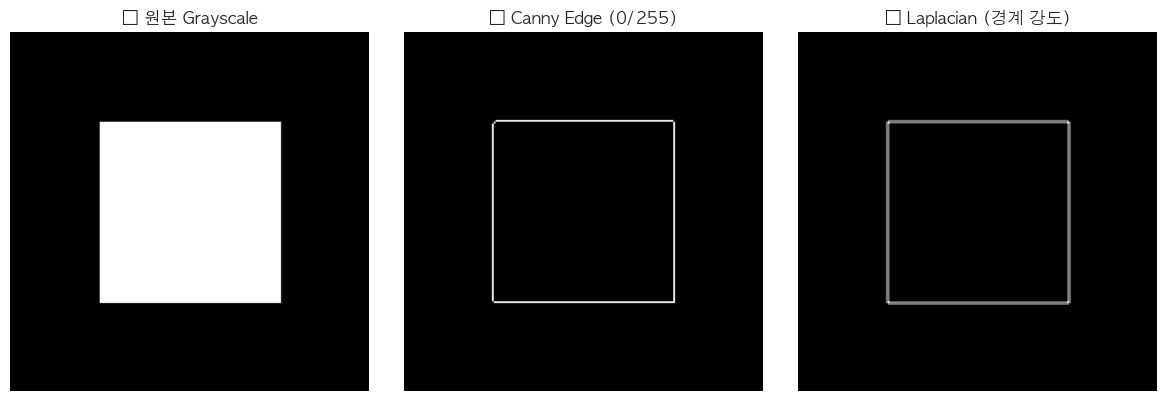

In [6]:
img = np.zeros((200, 200), dtype=np.uint8)
cv2.rectangle(img, (50, 50), (150, 150), 255, -1)

gray = img.copy()
edges = cv2.Canny(gray, 100, 200)

laplacian = cv2.Laplacian(gray, cv2.CV_64F)

# 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(gray, cmap='gray')
plt.title("🖼 원본 Grayscale")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title("🧱 Canny Edge (0/255)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(laplacian), cmap='gray')
plt.title("📐 Laplacian (경계 강도)")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import shutil

# 이미지 20장 랜덤 추출 (test set 기준)
src_img_dir = Path("data/test/images")
dst_img_dir = Path("data/test_sample/images")
dst_img_dir.mkdir(parents=True, exist_ok=True)

# 랜덤 20장 추출 및 복사
sample_imgs = random.sample(
    [f for f in src_img_dir.iterdir() if f.suffix in [".jpg", ".png"]],
    20
)
for img_path in sample_imgs:
    shutil.copy(img_path, dst_img_dir / img_path.name)

print(f"샘플 추출 완료: {len(sample_imgs)}장 → {dst_img_dir}")


샘플 추출 완료: 20장 → data/test_sample/images


In [46]:
def visualize_yolo_labeled_image(img_path, label_path, class_names=None):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # 바운딩 박스 불러오기
    boxes = []
    with open(label_path, "r") as f:
        for line in f.readlines():
            cls, cx, cy, bw, bh = map(float, line.strip().split())
            x1 = int((cx - bw / 2) * w)
            y1 = int((cy - bh / 2) * h)
            x2 = int((cx + bw / 2) * w)
            y2 = int((cy + bh / 2) * h)
            boxes.append((int(cls), x1, y1, x2, y2))

    for cls, x1, y1, x2, y2 in boxes:
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        label = class_names[int(cls)] if class_names else str(cls)
        cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(img_path.name)
    plt.axis('off')
    plt.show()

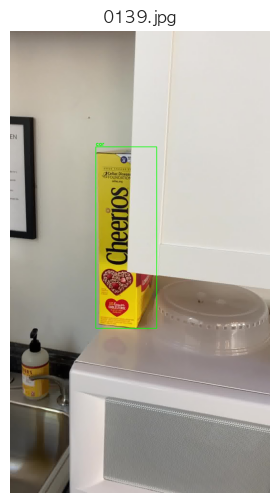

In [47]:
extract_dir = Path("data/test_sample/labels")

img_file = list(dst_img_dir.glob("*.jpg"))[0]
label_file = extract_dir / (img_file.stem + ".txt")
visualize_yolo_labeled_image(img_file, label_file, class_names=["car", "bus", "bicycle", "person"])


In [51]:
# YOLO label 폴더 경로 (Synthetic 전용)
label_dir = Path("data/train/labels")

# 클래스 수 추적 및 객체 박스 통계 저장용
class_counts = {}
object_sizes = []
image_object_counts = []

# 이미지 해상도는 없으므로 기본 가정 (YOLO 포맷은 상대좌표 기준)
default_width, default_height = 1.0, 1.0  # 상대값이라서 의미 없음 (1기준)

# 라벨 파일 순회
for label_file in label_dir.glob("*.txt"):
    with open(label_file, "r") as f:
        lines = f.readlines()

    image_object_counts.append(len(lines))  # 이미지당 객체 수 기록

    for line in lines:
        cls_id, x_center, y_center, width, height = map(float, line.strip().split())
        class_counts[int(cls_id)] = class_counts.get(int(cls_id), 0) + 1

        area = width * height  # 상대 면적
        object_sizes.append({
            "class": int(cls_id),
            "width": width,
            "height": height,
            "area": area,
            "filename": label_file.name
        })

# 데이터프레임 정리
df_class = pd.DataFrame(list(class_counts.items()), columns=["class", "count"])
df_sizes = pd.DataFrame(object_sizes)
df_counts = pd.DataFrame(image_object_counts, columns=["objects_per_image"])

# 시각화를 위해 반환

print("클래스별 객체 수")
display(df_class)
print("객체 크기 통계")
display(df_sizes)
print("이미지 당 객체 수")
display(df_counts)


클래스별 객체 수


class  count
0      0    424

객체 크기 통계


class     width    height      area       filename
0        0  0.147396  0.246296  0.036303  000000371.txt
1        0  0.132292  0.206481  0.027316  000000832.txt
2        0  0.366146  0.501852  0.183751  000000167.txt
3        0  0.138021  0.164815  0.022748  000000601.txt
4        0  0.098437  0.260185  0.025612  000000749.txt
..     ...       ...       ...       ...            ...
419      0  0.229687  0.317593  0.072947  000000142.txt
420      0  0.079167  0.071296  0.005644  000000156.txt
421      0  0.114062  0.037963  0.004330  000000817.txt
422      0  0.104167  0.256481  0.026717  000000426.txt
423      0  0.142187  0.128704  0.018300  000000432.txt

[424 rows x 5 columns]

이미지 당 객체 수


objects_per_image
0                    1
1                    1
2                    1
3                    1
4                    1
..                 ...
426                  1
427                  1
428                  1
429                  1
430                  1

[431 rows x 1 columns]

In [57]:
df_counts[df_counts['objects_per_image']==0]

objects_per_image
188                  0
237                  0
270                  0
280                  0
296                  0
369                  0
415                  0

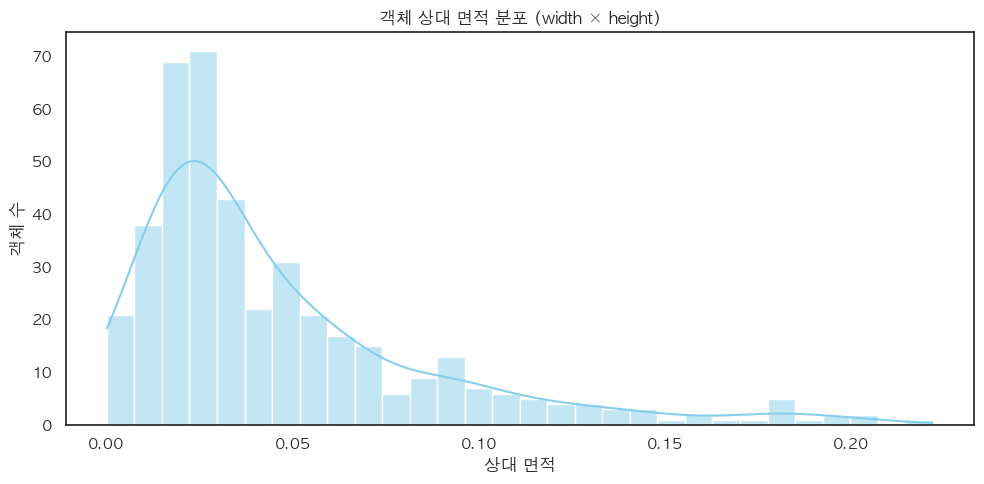

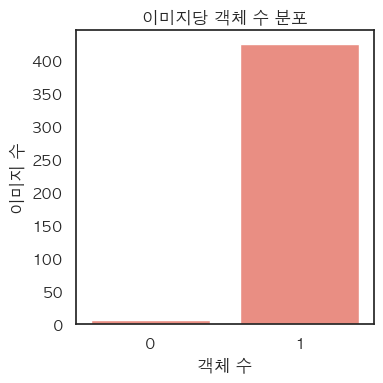

In [66]:
# 시각화: 객체 면적 분포
plt.figure(figsize=(10, 5))
sns.histplot(df_sizes["area"], bins=30, kde=True, color="skyblue")
plt.title("객체 상대 면적 분포 (width × height)")
plt.xlabel("상대 면적")
plt.ylabel("객체 수")
plt.tight_layout()
plt.show()

# 시각화: 이미지당 객체 수 분포
plt.figure(figsize=(4, 4))
sns.barplot(df_counts["objects_per_image"].value_counts(), color="salmon")
plt.title("이미지당 객체 수 분포")
plt.xlabel("객체 수")
plt.ylabel("이미지 수")
plt.tight_layout()
plt.show()


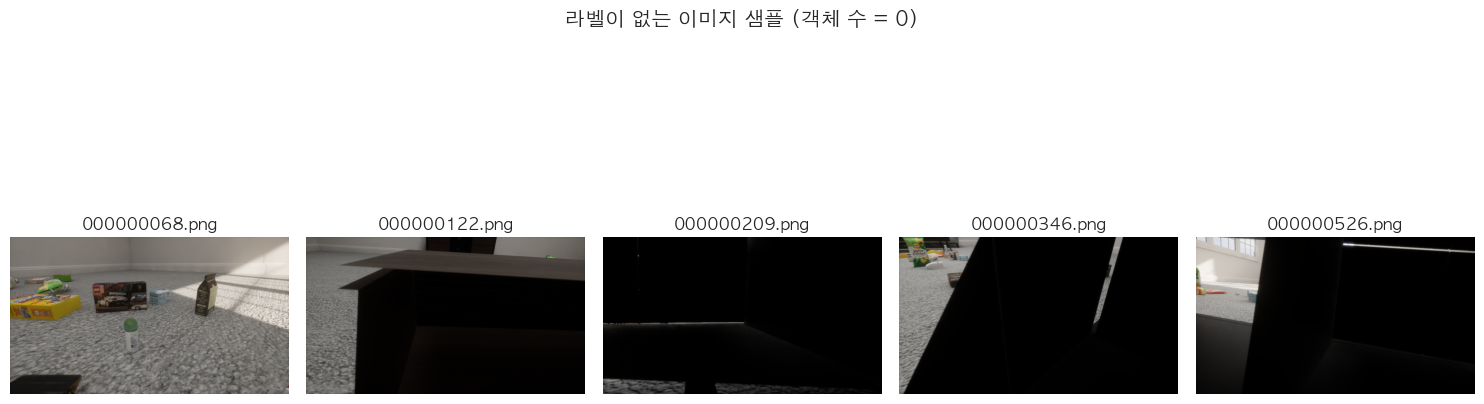

In [68]:
# 라벨이 없는 이미지 찾기
image_dir = Path("data/train/images")
label_dir = Path("data/train/labels")

# 모든 이미지 중 라벨 파일이 없거나 빈 라벨 파일만 선택
image_files = sorted([f for f in image_dir.glob("*") if f.suffix in [".jpg", ".png"]])
empty_images = []

for img_path in image_files:
    label_path = label_dir / (img_path.stem + ".txt")
    if not label_path.exists():
        empty_images.append(img_path)
    else:
        with open(label_path, "r") as f:
            if f.read().strip() == "":
                empty_images.append(img_path)

# 상위 5장만 시각화
n = min(5, len(empty_images))
plt.figure(figsize=(15, 6))
for i in range(n):
    img = cv2.imread(str(empty_images[i]))
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(empty_images[i].name)
        plt.axis('off')
plt.suptitle("라벨이 없는 이미지 샘플 (객체 수 = 0)")
plt.tight_layout()
plt.show()


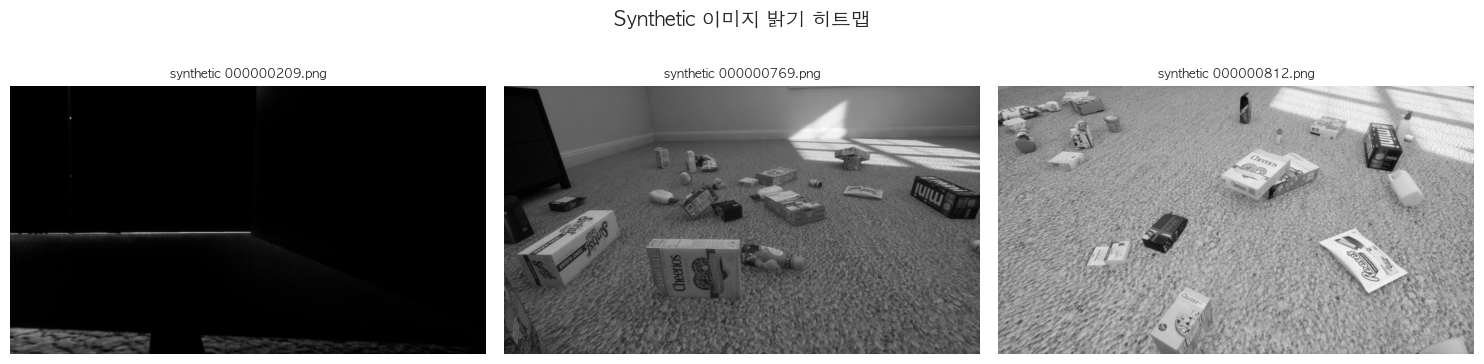

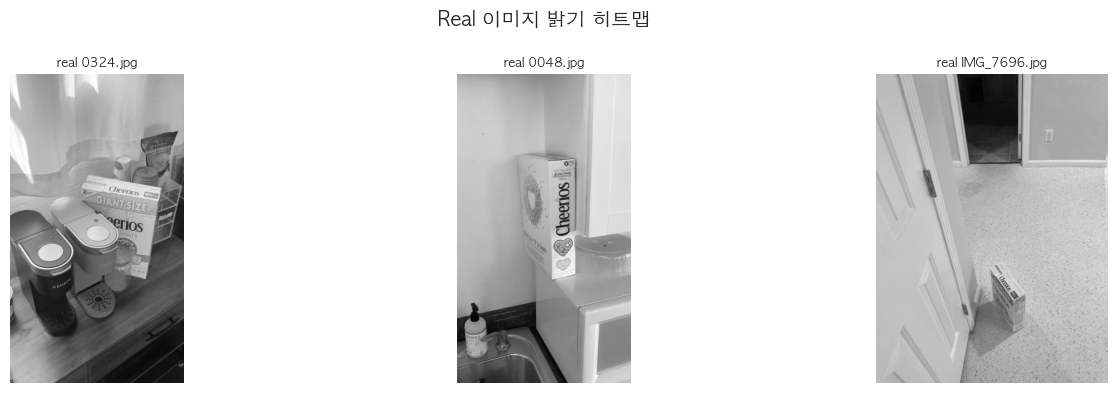

In [72]:
# 경로 설정
train_dir = Path("data/train/images")
test_dir = Path("data/test/images")

# 무작위 샘플 이미지 선택
train_imgs = sorted([f for f in train_dir.glob("*") if f.suffix.lower() in [".jpg", ".png"]])
test_imgs = sorted([f for f in test_dir.glob("*") if f.suffix.lower() in [".jpg", ".png"]])

sample_train = random.sample(train_imgs, 3)
sample_test = random.sample(test_imgs, 3)

def show_brightness_heatmaps(img_paths, domain):
    plt.figure(figsize=(15, 4))
    for i, img_path in enumerate(img_paths):
        img = cv2.imread(str(img_path))
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        value_channel = hsv[:, :, 2]  # 밝기 (Value)

        plt.subplot(1, len(img_paths), i + 1)
        plt.imshow(value_channel, cmap="gray")
        plt.title(f"{domain} {img_path.name}", fontsize=9)
        plt.axis("off")
    plt.suptitle(f"{domain.capitalize()} 이미지 밝기 히트맵", fontsize=14)
    plt.tight_layout()
    plt.show()

# 밝기 히트맵 시각화
show_brightness_heatmaps(sample_train, "synthetic")
show_brightness_heatmaps(sample_test, "real")


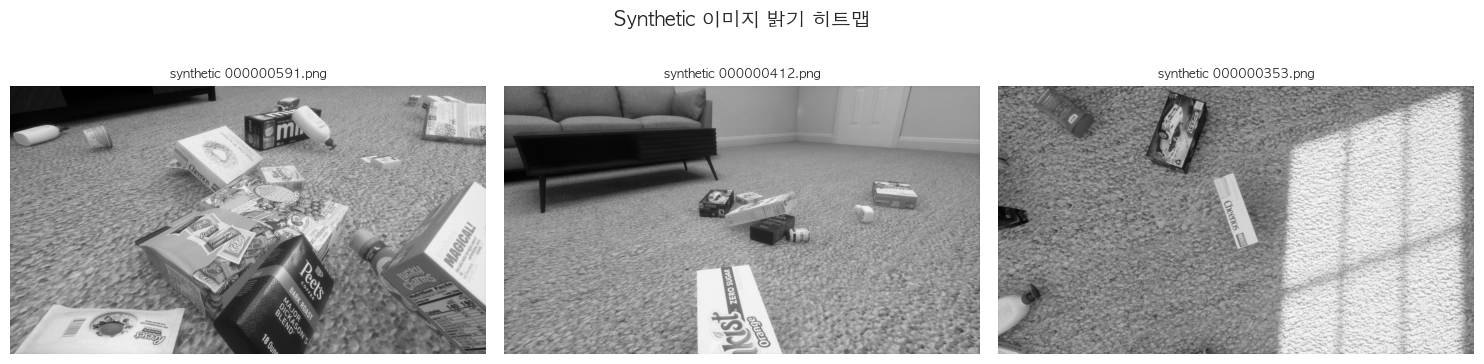

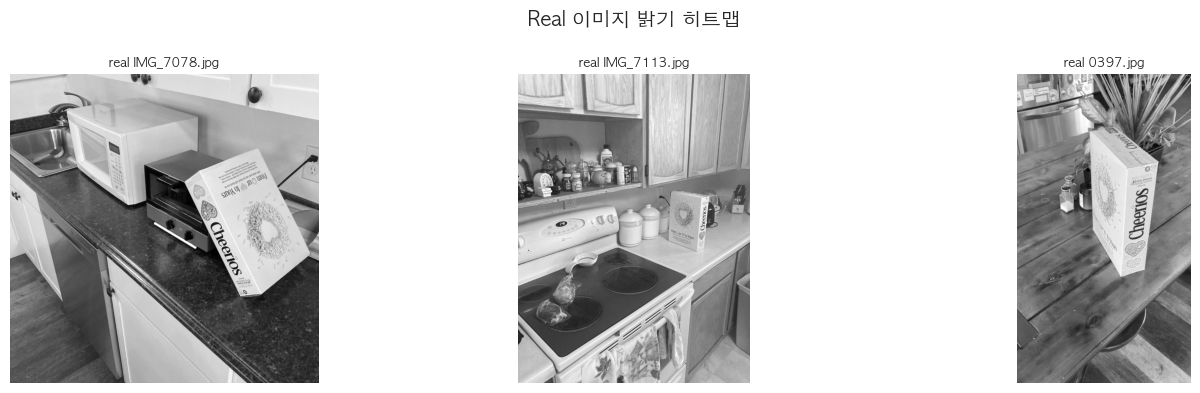

In [73]:
# 샘플 수 오류 방지: 가능한 만큼만 추출
sample_train = random.sample(train_imgs, min(3, len(train_imgs)))
sample_test = random.sample(test_imgs, min(3, len(test_imgs)))

# 밝기 히트맵 시각화 함수 실행
show_brightness_heatmaps(sample_train, "synthetic")
show_brightness_heatmaps(sample_test, "real")


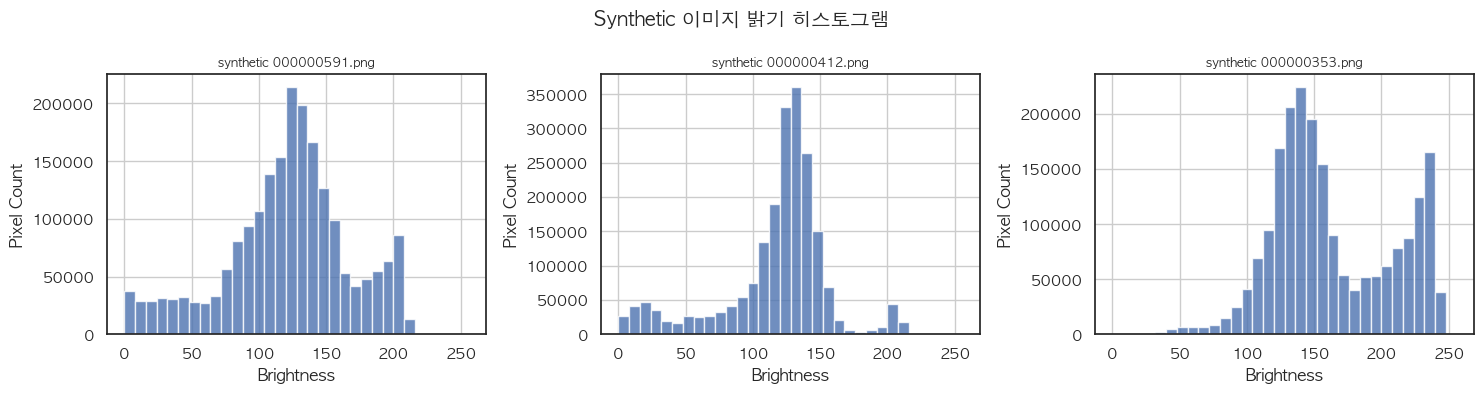

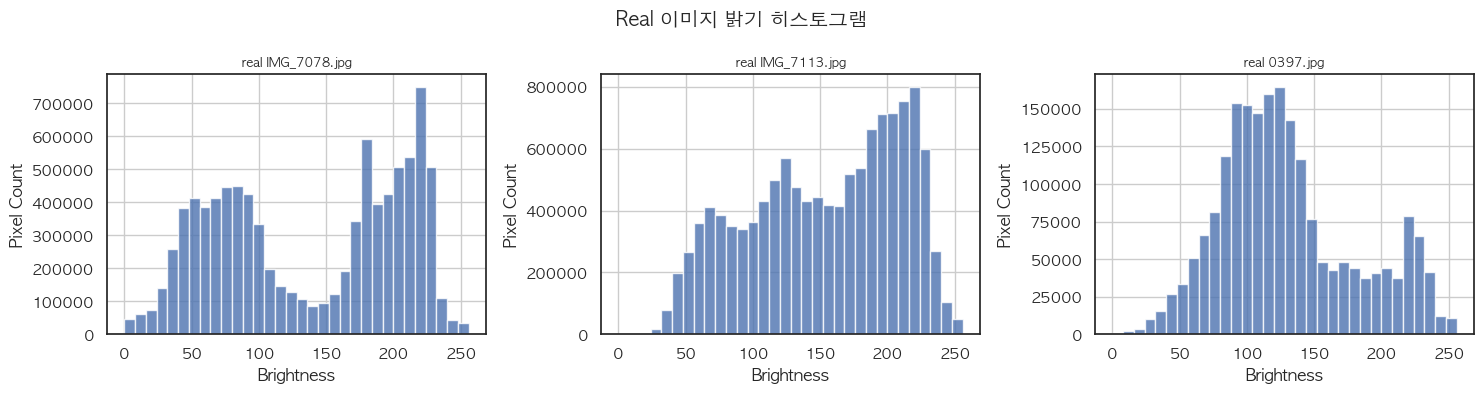

In [76]:
# 이미지별 밝기 히스토그램을 시각화

def show_brightness_histograms(img_paths, domain):
    plt.figure(figsize=(15, 4))
    for i, img_path in enumerate(img_paths):
        img = cv2.imread(str(img_path))
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        value_channel = hsv[:, :, 2]

        plt.subplot(1, len(img_paths), i + 1)
        plt.hist(value_channel.ravel(), bins=32, range=(0, 256), alpha=0.8)
        plt.title(f"{domain} {img_path.name}", fontsize=9)
        plt.xlabel("Brightness")
        plt.ylabel("Pixel Count")
        plt.grid(True)
    plt.suptitle(f"{domain.capitalize()} 이미지 밝기 히스토그램", fontsize=14)
    plt.tight_layout()
    plt.show()

# Synthetic / Real 이미지 밝기 히스토그램 시각화
show_brightness_histograms(sample_train, "synthetic")
show_brightness_histograms(sample_test, "real")


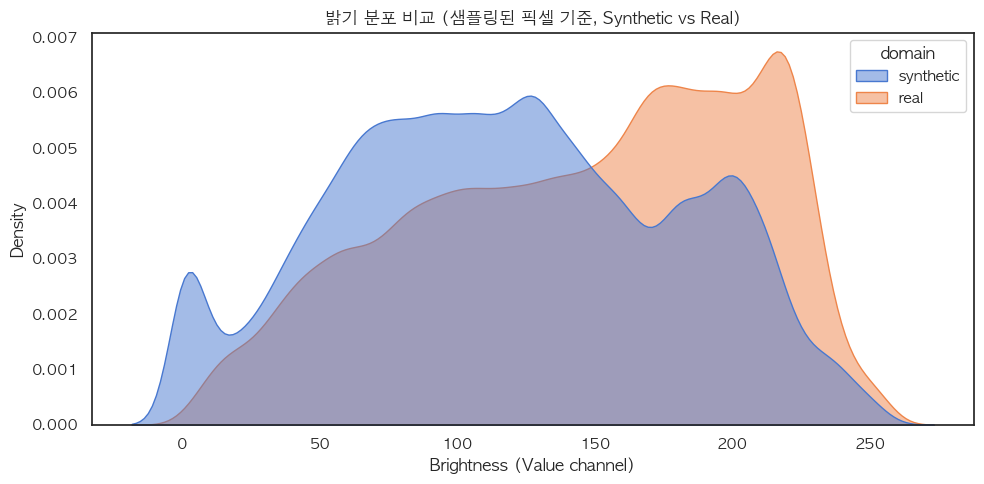

In [79]:
# 경로 설정
train_dir = Path("data/train/images")
test_dir = Path("data/test/images")

# 각 도메인에서 5장씩 무작위 샘플링
sample_train_imgs = random.sample(list(train_dir.glob("*.png")) + list(train_dir.glob("*.jpg")), k=100)
sample_test_imgs = random.sample(list(test_dir.glob("*.png")) + list(test_dir.glob("*.jpg")), k=100)

def sample_brightness(img_paths, domain, samples_per_image=1000):
    values = []
    for img_path in img_paths:
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        v = hsv[:, :, 2].flatten()
        values.extend(random.sample(list(v), min(samples_per_image, len(v))))
    return pd.DataFrame({"brightness": values, "domain": domain})

# 밝기 샘플 수집
df_syn = sample_brightness(sample_train_imgs, "synthetic")
df_real = sample_brightness(sample_test_imgs, "real")
df_combined = pd.concat([df_syn, df_real], ignore_index=True)

# 시각화
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df_combined, x="brightness", hue="domain", fill=True, common_norm=False, palette="muted", alpha=0.5)
plt.title("밝기 분포 비교 (샘플링된 픽셀 기준, Synthetic vs Real)")
plt.xlabel("Brightness (Value channel)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()
